In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense,Dropout,Activation,Conv2D,MaxPooling2D,BatchNormalization,Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint
from tensorflow.keras.models import load_model
import cv2
from PIL import Image
import numpy as np
import pandas as pd
import os
from tensorflow.keras.utils import to_categorical
import seaborn as sns

2023-12-17 22:06:47.165954: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-17 22:06:47.200914: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-17 22:06:47.200948: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-17 22:06:47.202039: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-17 22:06:47.206668: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2023-12-17 22:06:47.207267: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [4]:
int2emotions = {0:'angry',1:'disgust',2:'fear',3:'happy',4:'neutral',5:'sad',6:'surprise'}
emotions2int = {'angry':0,'disgust':1,'fear':2,'happy':3,'neutral':4,'sad':5,'surprise':6}

dic = {'images':[], 'labels':[], 'purpose':[]}
    
for d in os.listdir('fer2013/'):
    print(d)
    for emotion in os.listdir(f'fer2013/{d}'):
        print(emotion)
        for i in os.listdir(f'fer2013/{d}/{emotion}'):
            img = cv2.imread(f'fer2013/{d}/{emotion}/{i}',0)
            img = img.reshape(48,48,1)
            
            dic['images'].append(img)
            dic['labels'].append(emotion)
            
            if d=='train':
                dic['purpose'].append('T')
            else:
                dic['purpose'].append('V')

validation
neutral
disgust
happy
sad
angry
surprise
fear
train
neutral
disgust
happy
sad
angry
surprise
fear


In [5]:
df = pd.DataFrame(dic)
df.head()

,images,labels,purpose
0,"[[[255], [253], [255], [255], [252], [255], [2...",neutral,V
1,"[[[83], [73], [51], [41], [45], [47], [30], [2...",neutral,V
2,"[[[147], [152], [159], [92], [24], [26], [22],...",neutral,V
3,"[[[179], [63], [27], [49], [72], [92], [119], ...",neutral,V
4,"[[[121], [120], [120], [121], [122], [113], [9...",neutral,V


In [6]:
train_data = df[df['purpose']=='T']
val_data = df[df['purpose']=='V']

In [7]:
train_data.head()

,images,labels,purpose
7178,"[[[244], [243], [244], [242], [251], [214], [1...",neutral,T
7179,"[[[123], [126], [125], [130], [135], [108], [6...",neutral,T
7180,"[[[227], [104], [47], [51], [50], [50], [67], ...",neutral,T
7181,"[[[25], [19], [22], [24], [19], [19], [25], [2...",neutral,T
7182,"[[[192], [191], [208], [208], [209], [194], [2...",neutral,T


In [8]:
val_data.head()

,images,labels,purpose
0,"[[[255], [253], [255], [255], [252], [255], [2...",neutral,V
1,"[[[83], [73], [51], [41], [45], [47], [30], [2...",neutral,V
2,"[[[147], [152], [159], [92], [24], [26], [22],...",neutral,V
3,"[[[179], [63], [27], [49], [72], [92], [119], ...",neutral,V
4,"[[[121], [120], [120], [121], [122], [113], [9...",neutral,V


In [9]:
train_data['labels'].value_counts()

labels
happy       7215
neutral     4965
sad         4830
fear        4097
angry       3995
surprise    3171
disgust      436
Name: count, dtype: int64

In [10]:
val_data['labels'].value_counts()

labels
happy       1774
sad         1247
neutral     1233
fear        1024
angry        958
surprise     831
disgust      111
Name: count, dtype: int64

In [11]:
min_samples = min(
    len(train_data[train_data['labels'] == 'happy']),
    len(train_data[train_data['labels'] == 'disgust']),
    len(train_data[train_data['labels'] == 'neutral']),
    len(train_data[train_data['labels'] == 'sad']),
    len(train_data[train_data['labels'] == 'fear']),
    len(train_data[train_data['labels'] == 'angry']),
    len(train_data[train_data['labels'] == 'surprise'])
)
print(min_samples)

if min_samples > 0:
    happy_df = train_data[train_data['labels'] == 'happy'].sample(n=min_samples)
    disgust_df = train_data[train_data['labels'] == 'disgust'].sample(n=min_samples)
    neutral_df = train_data[train_data['labels'] == 'neutral'].sample(n=min_samples)
    sad_df = train_data[train_data['labels'] == 'sad'].sample(n=min_samples)
    fear_df = train_data[train_data['labels'] == 'fear'].sample(n=min_samples)
    angry_df = train_data[train_data['labels'] == 'angry'].sample(n=min_samples)
    surprise_df = train_data[train_data['labels'] == 'surprise'].sample(n=min_samples)

    train_data = pd.concat([happy_df, disgust_df, neutral_df, sad_df, fear_df, angry_df, surprise_df])

    train_data = train_data.sample(frac=1)
    train_data.reset_index(inplace=True)
    train_data.drop('index', inplace=True, axis=1)

    train_data.head()
else:
    print("Not enough samples for each class. Adjust the sampling strategy.")


436


In [12]:
train_data['labels'].value_counts()

labels
happy       436
surprise    436
neutral     436
disgust     436
fear        436
angry       436
sad         436
Name: count, dtype: int64

<Axes: xlabel='count', ylabel='labels'>

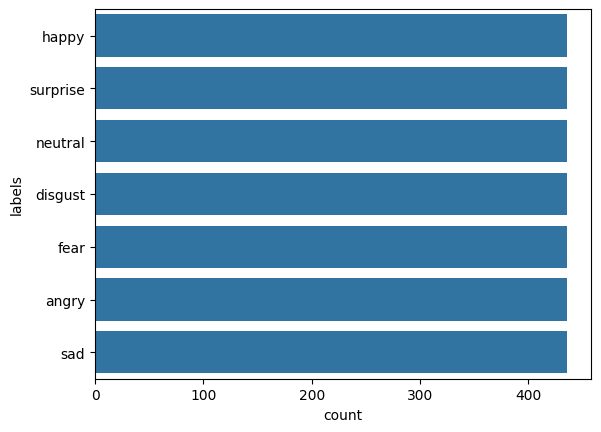

In [13]:
sns.countplot(train_data['labels'])

In [14]:
batch_size= 32
classes = 7
rows,columns=48,48

In [15]:
train_labels = list(train_data['labels'].replace(emotions2int))
train_labels = to_categorical(train_labels)

val_labels = list(val_data['labels'].replace(emotions2int))
val_labels = to_categorical(val_labels)

In [16]:
train_data = list(train_data['images'])
train_data = np.array(train_data)

val_data = list(val_data['images'])
val_data = np.array(val_data)

In [17]:
train_data.shape

(3052, 48, 48, 1)

In [18]:
val_data.shape

(7178, 48, 48, 1)

In [19]:
# batch_size= 32
# classes = 6
# rows,columns=48,48

# train_dir = 'fer2013\\train' 
# validation_dir = 'fer2013\\validation'

# train_gen = ImageDataGenerator(rescale=1./255,
#                               rotation_range=45,
#                               height_shift_range=0.3,
#                               width_shift_range=0.3,
#                               shear_range=0.2,
#                               horizontal_flip=True,
#                               fill_mode='nearest')

# validation_gen = ImageDataGenerator(rescale=1./255)

# training_data_generator = train_gen.flow_from_directory(train_dir,
#                                                        batch_size=batch_size,
#                                                        shuffle=True,
#                                                        color_mode='grayscale',
#                                                        class_mode='categorical',
#                                                        target_size=(rows,columns))

# valiadtion_data_generator = validation_gen.flow_from_directory(validation_dir,
#                                                        batch_size=batch_size,
#                                                        shuffle=False,
#                                                        color_mode='grayscale',
#                                                        class_mode='categorical',
#                                                        target_size=(rows,columns))




## Creating Our Model

In [20]:
model = Sequential()

# First Block
model.add(Conv2D(64,(3,3),activation='elu',input_shape=(rows,columns,1),kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3),activation='elu',input_shape=(rows,columns,1),kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Second Block
model.add(Conv2D(128,(3,3),activation='elu',kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3),activation='elu',kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Third Block
model.add(Conv2D(256,(3,3),activation='elu',kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256,(3,3),activation='elu',kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Fourth Block
model.add(Conv2D(512,(3,3),activation='elu',kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(512,(3,3),activation='elu',kernel_initializer='he_normal',padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.2))

# Fifth Block
model.add(Flatten())
model.add(Dense(256,activation='elu',kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Sixth Block
model.add(Dense(128,activation='elu',kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Seventh Block
model.add(Dense(64,activation='elu',kernel_initializer='he_normal'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

# Eighth Block
model.add(Dense(classes,activation='softmax',kernel_initializer='he_normal'))

print(model.summary())

2023-12-17 22:06:55.476395: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-12-17 22:06:55.476824: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 batch_normalization_1 (Bat  (None, 48, 48, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                              
                                                        

In [21]:
checkpoint = ModelCheckpoint('model\\7_class_emotion_detector_V2.h5',
                             save_best_only=True,
                             mode='min',
                             monitor='val_loss',
                             verbose=1)

earlystopping = EarlyStopping(patience=10,
                             verbose=1,
                             min_delta=0,
                             monitor='val_loss',
                             restore_best_weights=True)


callbacks = [checkpoint, earlystopping]

model.compile(metrics=['accuracy'],
             optimizer='rmsprop',
             loss='categorical_crossentropy')

train_samples = 28273
validation_samples = 3534
batch_size = 64
epochs=30

# Training Our Model

In [22]:
#history = model.fit(train_data,
#                    train_labels,
#                    epochs=epochs,
#                    steps_per_epoch=train_samples//batch_size,
#                    validation_data=(val_data,val_labels),
#                    validation_steps=validation_samples//batch_size,
#                    callbacks=callbacks)

# Live Predictor

In [23]:
# Get the current working directory
current_dir = os.getcwd()

# Use os.path.join for constructing the file paths
cascade_path = os.path.join(current_dir, 'Haarcascades', 'haarcascade_frontalface_default.xml')
model_path = os.path.join(current_dir, 'model', '7_class_emotion_detector_V2.h5')

# Load the Haar Cascade classifier
classifier = cv2.CascadeClassifier(cascade_path)

# Load the model
model = load_model(model_path)

cap = cv2.VideoCapture(0)

def detect_face(frame):
    faces = classifier.detectMultiScale(frame, 1.3, 4)
    if len(faces) == 0:
        return frame

    for x, y, w, h in faces:
        cv2.rectangle(frame, (x, y), (x+w, y+h), (172, 42, 251), 2)
        face = frame[y:y+h, x:x+w]
        face = cv2.cvtColor(face, cv2.COLOR_BGR2GRAY)
        face = cv2.resize(face, (48, 48))
        face = face.reshape(1, 48, 48, 1)
        cv2.putText(frame, text=int2emotions[np.argmax(model.predict(face))],
                    org=(x, y-15), fontFace=cv2.FONT_HERSHEY_SIMPLEX, fontScale=1, color=(106, 40, 243), thickness=2)
    return frame


while 1:
    ret,frame= cap.read()
    if ret==True:
        cv2.imshow('emotion_detector',detect_face(frame))
        if cv2.waitKey(1)==27:
            break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 33ms/step


KeyboardInterrupt: 

: 